# 2º Trabalho de avaliação de visão computacional

Dados:
- Nome: Guilherme Guy de Andrade
- Matrícula: 22/0004641

## Requisitos
- pip
- pipenv
- ipykernel *(para a execução do notebook)*

É necessário o arquivo Pipfile do repositório para possibilitar a instalação das dependências.

## Repositório do projeto
- [https://github.com/guilherme1guy/computer_vision](https://github.com/guilherme1guy/computer_vision)

## Execução:
Execute as células do Jupyter Notebook


Instalar dependências e importar pacotes:

In [453]:
%%capture
# Instalar dependências
! pip install pipenv
! pipenv install

# Importar pacotes

import numpy as np
import scipy
from PIL import Image
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import skimage
from numba import jit, njit, prange
import cv2 as cv

Funções auxiliares:

In [424]:
# Funções gerais

def show_image(image: np.ndarray, title = None):
    # show grayscale image as actually a grayscale image
    if title:
        plt.title(title)

    plt.imshow(image, cmap='gray', vmin=0, vmax=255)


def show_images(images: np.ndarray):
    for image in images:
        show_image(image)
        plt.show()

def show_images_side_by_side(*images: np.ndarray, graph_titles: list[str] = [], bounds = None, figsize = (20, 20)):

    # auto generate graph titles if none are provided
    if len(graph_titles) == 0:
        graph_titles = [f"Image {i}" for i in range(0, len(images))]

    if len(graph_titles) != len(images):
        raise ValueError('graph_titles must have the same length as images')

    # show images side by side
    _, axs = plt.subplots(1, len(images), figsize=figsize)

    try:
        axs[0]
    except:
        axs = [axs]

    for i in range(0, len(images)):

        extent = None
        if bounds and i < len(bounds):
            extent = bounds[i]
            print(f"bounds = {bounds}")

        axs[i].imshow(images[i], cmap='gray', extent=extent, vmin=0, vmax=255)
        axs[i].set_title(graph_titles[i])


    plt.show()

def show_multiple_intensity_graphs(*images: np.ndarray, graph_titles: list[str] = []):
    # show intensity histograms on different figures, stacked

    # auto generate graph titles if none are provided
    if len(graph_titles) == 0:
        graph_titles = [f"Intensity Histogram {i}" for i in range(0, len(images))]

    if len(graph_titles) != len(images):
        raise ValueError('graph_titles must have the same length as images')

    for i, image in enumerate(images):
        show_intensity_graph(image, graph_titles[i])

def show_intensity_graph(image: np.ndarray, graph_title: str = "Intensity Histogram"):
    display_height = image.shape[0] // 2

    plt.figure(figsize=(10, 2))

    # plot instensity value along a line
    plt.bar(
        range(0, image.shape[1]),
        image[display_height, :]
    )

    # value is not 255 to show a bit of blank space on top
    # of the graph
    plt.ylim((0, 255 + 20))

    plt.title(graph_title)

    plt.xlabel('Pixel')
    plt.ylabel('Intensity Value')
    plt.show()

def show_intensity_graph_side_by_side(images: list[np.ndarray], graph_titles):
    _, axs = plt.subplots(1, len(images), figsize=(20, 5))

    for i in range(0, len(images)):
        axs[i].bar(
            range(0, images[i].shape[1]),
            images[i][images[i].shape[0] // 2, :]
        )

        axs[i].set_ylim(0, 255 + 20)

        axs[i].set_title(graph_titles[i])

    plt.show()

# plot intensity graph and std_deviation line graph

def plot_intensity_graph_with_std_deviation(image: np.ndarray, std_deviation: np.ndarray):
    display_height = image.shape[0] // 2

    # plot instensity value along a line
    fig, ax = plt.subplots()
    ax.plot(image[display_height, :], color='green')

    # get transparent red color
    red = (1, 0, 0, 0.3)
    ax.plot(image[display_height, :] + std_deviation[display_height, :], color=red)
    ax.plot(image[display_height, :] - std_deviation[display_height, :], color=red)

    # value is not 255 to show a bit of blank space on top
    # of the graph
    plt.ylim((0, 255 + 20))

    # set size of graph
    fig.set_figheight(4)
    fig.set_figwidth(15)

    # add labels
    plt.title("Intensity Graph with Standard Deviation")
    plt.xlabel('Pixel')

    plt.show(fig)


def plot_all_intensity_graph_with_std_deviation(images: np.ndarray, std_deviation: np.ndarray, avg_img: np.ndarray):
    display_height = images.shape[1] // 2

    # plot instensity value along a line
    fig, ax = plt.subplots()
    blue = (0, 0, 1, 0.1)
    for i in range(0, len(images)):
        ax.plot(images[i][display_height, :], color=blue)

    ax.plot(avg_img[display_height, :], color='green')

    # get transparent red color
    red = (1, 0, 0, 0.5)
    ax.plot(avg_img[display_height, :] + std_deviation[display_height, :], color=red)
    ax.plot(avg_img[display_height, :] - std_deviation[display_height, :], color=red)

    # value is not 255 to show a bit of blank space on top
    # of the graph
    plt.ylim((0, 255 + 20))

    # set size of graph
    fig.set_figheight(4)
    fig.set_figwidth(15)

    # add labels
    plt.title("Intensity Graph with Standard Deviation")
    plt.xlabel('Pixel')

    plt.show(fig)


def load_images(pattern: str = None, files: list = None):

    if pattern is None and files is None:
        raise ValueError('pattern or files must be provided')
    
    if pattern is not None:
        files = sorted(glob(pattern))
    else:
        files = sorted(files)

    images = []
    for f in files:
        image = Image.open(f)
        image = image.convert('L')
        images.append(np.array(image))
    images = np.array(images, dtype = object)

    return images

def normalize_images(images: np.ndarray):
    # normalize images to be displayed properly
    # by making the max value equal to 255

    new_images = np.copy(images)

    for i in range(0, len(new_images)):
        new_images[i] = new_images[i] / np.max(new_images[i]) * 255

    return new_images


# Questão 1.a


Implemente o algoritmo HOUGH_LINES. Use as imagens disponíveis no site ou outras que achar mais conveniente. (houghtest.bmp, traces.jpg). Verifique que o número e comprimento das retas obtidas depende dos limiares adotados. Construa o sistema de forma a mostrar os resultados como retas sobre a imagem original. Obs: Implemente o algoritmo HOUGH_LINES descrito nos slides do curso e use funções dos toolbox do MatLab apenas para comparação.

In [425]:
def to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan(y/x)
    return r, theta

def hough_lines(image: np.ndarray, step = 0.5, threshold = 1):

    # based on:
    # https://github.com/alyssaq/hough_transform/blob/master/hough_transform.py
    # and:
    # https://alyssaq.github.io/2014/understanding-hough-transform/

    # Rho range and Theta range creation
    width, height = image.shape
    max_distance = int(round(np.sqrt(width**2 + height**2)))

    thetas = np.deg2rad(np.arange(-90.0, 90.0, step))
    rhos = np.linspace(-max_distance, max_distance, max_distance * 2)

    # precauted values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    # A(R,T)
    # parametric space can also be called accumulator
    # Hough accumulator
    parametric_space = np.zeros((len(rhos), len(thetas)))

    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):

            # only consider edge pixels from the canny-input image
            if image[i, j] > 0:

                for theta_idx in range(len(thetas)):
                    rho = int(round(i * cos_t[theta_idx] + j * sin_t[theta_idx]))

                    # sum max distance so we can map negative values to the positive-indexed matrix
                    rho += max_distance

                    parametric_space[rho, theta_idx] += 1

    # threshold, remove all values bellow the threshold
    relative_threshold = np.mean(parametric_space) * threshold
    parametric_space[parametric_space < relative_threshold] = 0

    # find local maxima using skimage
    parametric_diagonal_length = int(round(np.sqrt(len(rhos)**2 + len(thetas)**2)))
    local_maxima = skimage.feature.peak_local_max(
        parametric_space,
        min_distance=round(parametric_diagonal_length * 0.5 / 100),
        num_peaks=15
    )

    # draw lines on image
    new_image = np.array([image * 255, image * 255, image * 255])
    new_image = np.transpose(new_image, (1, 2, 0))

    for i in range(0, len(local_maxima)):
        # rho was added with max_distance to make it positive
        # now we remove it again
        rho = local_maxima[i][0] - max_distance

        theta_idx = local_maxima[i][1]

        # draw a blue line for each local maxima
        for x in range(0, image.shape[0]):
            # reverse from polar coordinates to image coordinates
            # we don't use the precalculated sin/cos here because we don't have
            # the index of the theta value, but the actual value
            y = -1
            try:
                y = int(
                    round(
                        (rho - x * cos_t[theta_idx]) / sin_t[theta_idx]
                    )
                )
            except:
                # sometimes the line is vertical, so we can't calculate y
                pass

            # bound check
            if y >= 0 and y < image.shape[1]:
                # color as blueish color
                new_image[x, y] = [0, 100, 255]

    return parametric_space, local_maxima, new_image


def hough_lines_lib(image: np.ndarray):

    # Classic straight-line Hough transform
    # Set a precision of 0.5 degree.
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = skimage.transform.hough_line(image, theta=tested_angles)

    # Generating figure 1
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(image, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [np.rad2deg(theta[0] - angle_step),
            np.rad2deg(theta[-1] + angle_step),
            d[-1] + d_step, d[0] - d_step]
    ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
    ax[1].set_title('Hough transform (Lib/Skimage)')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    ax[2].imshow(image, cmap=cm.gray)
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    for _, angle, dist in zip(*skimage.transform.hough_line_peaks(h, theta, d)):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

    plt.tight_layout()
    plt.show()

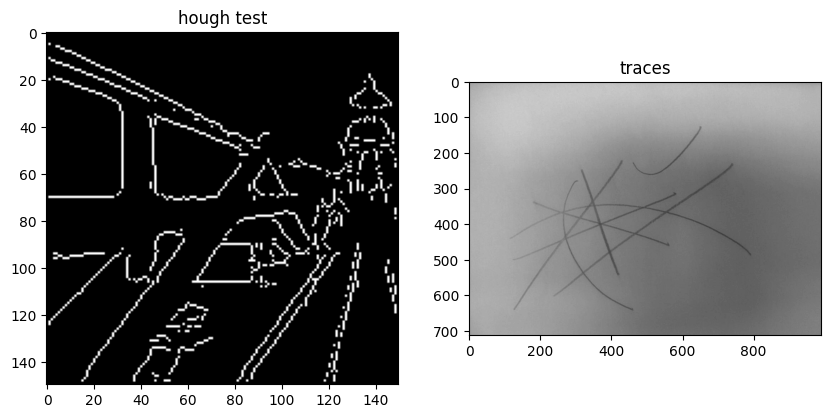

/home/gguy/.local/share/virtualenvs/computer_vision-zpGaL4pA/lib/python3.10/site-packages/numpy/lib/function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


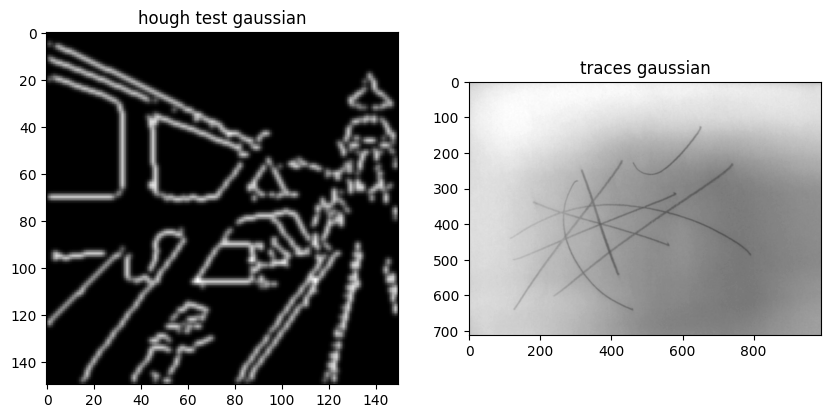

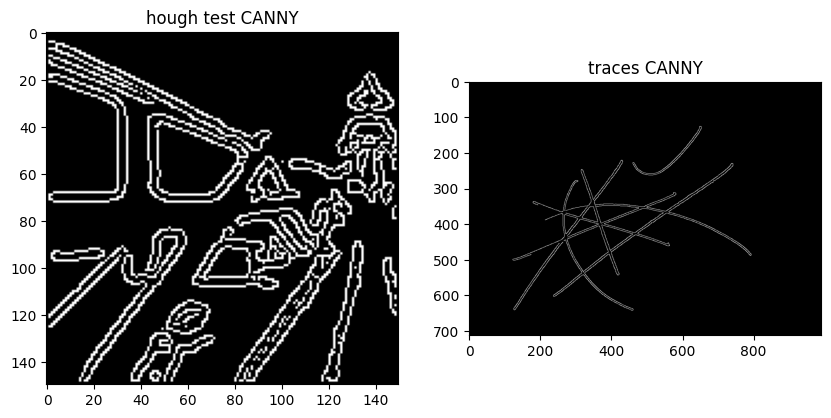

In [426]:
images = ['trab2/houghtest.bmp', 'trab2/traces.jpg']

IMAGES_1A = load_images(files = images)
show_images_side_by_side(*IMAGES_1A, graph_titles = ['hough test', 'traces'], figsize=(10, 10))

gaussian_1a = [skimage.filters.gaussian(image, sigma=1) for image in IMAGES_1A]
display_gauss = normalize_images(gaussian_1a)
show_images_side_by_side(*display_gauss, graph_titles = ['hough test gaussian', 'traces gaussian'], figsize=(10, 10))


edges_1a = [skimage.feature.canny(image, sigma=1) for image in gaussian_1a]
#edges[0] = IMAGES_1A[0]
display_edges = normalize_images(edges_1a)
show_images_side_by_side(*display_edges, graph_titles = ['hough test CANNY', 'traces CANNY'], figsize=(10, 10))

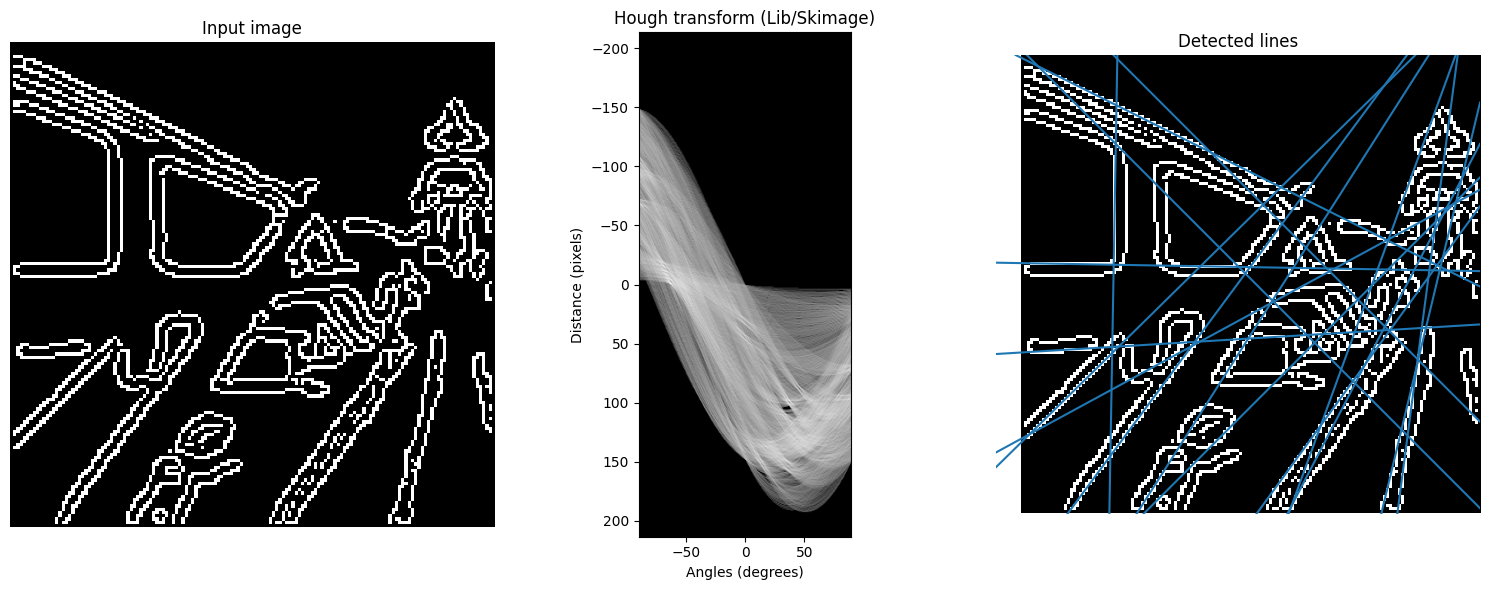

/tmp/ipykernel_422420/3165428027.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  (rho - x * cos_t[theta_idx]) / sin_t[theta_idx]
/tmp/ipykernel_422420/3165428027.py:75: RuntimeWarning: invalid value encountered in double_scalars
  (rho - x * cos_t[theta_idx]) / sin_t[theta_idx]


bounds = [[-90, 90, 212, -212]]


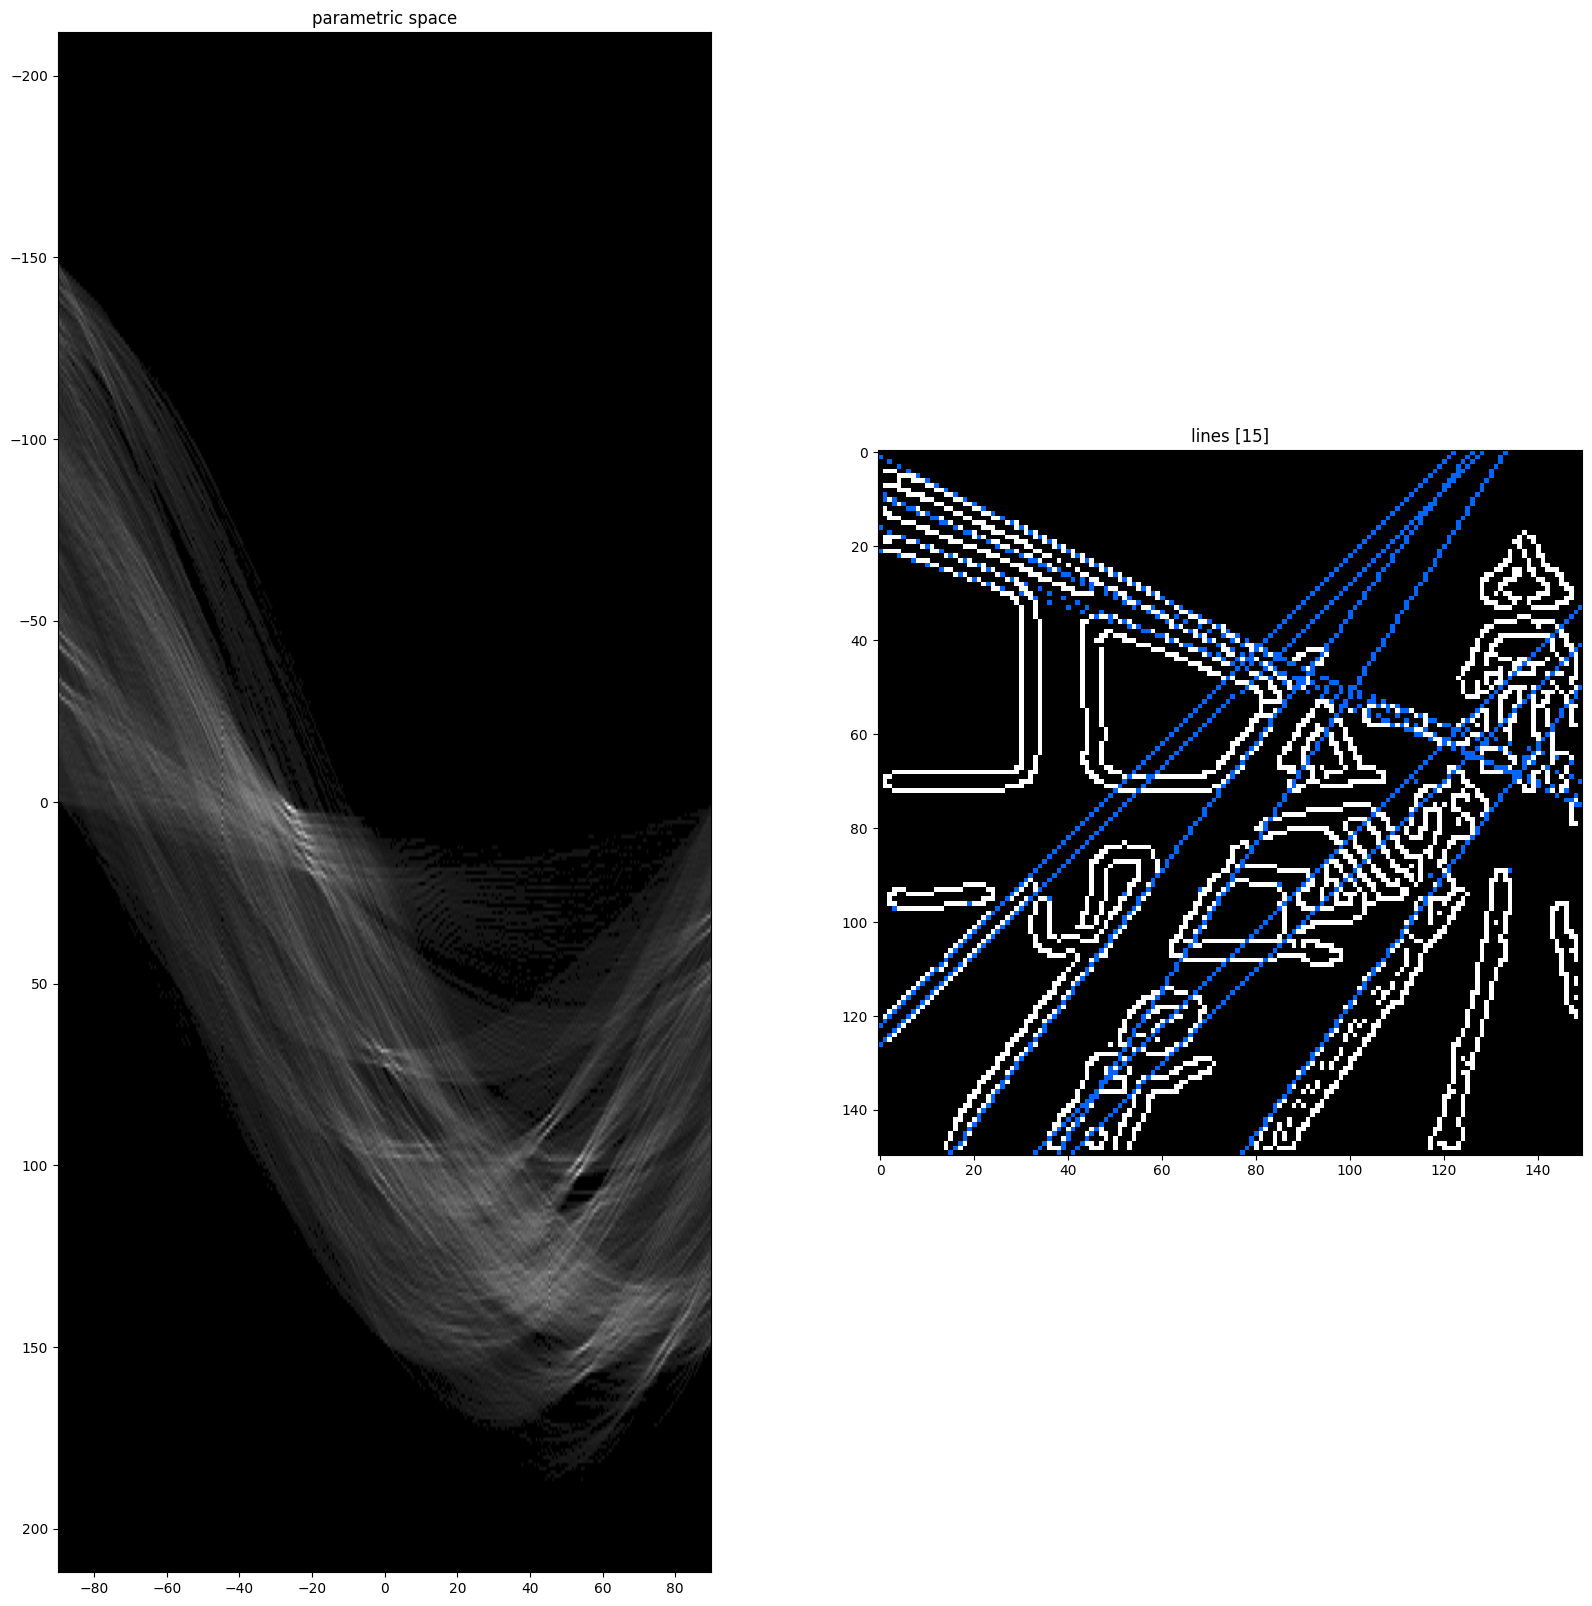

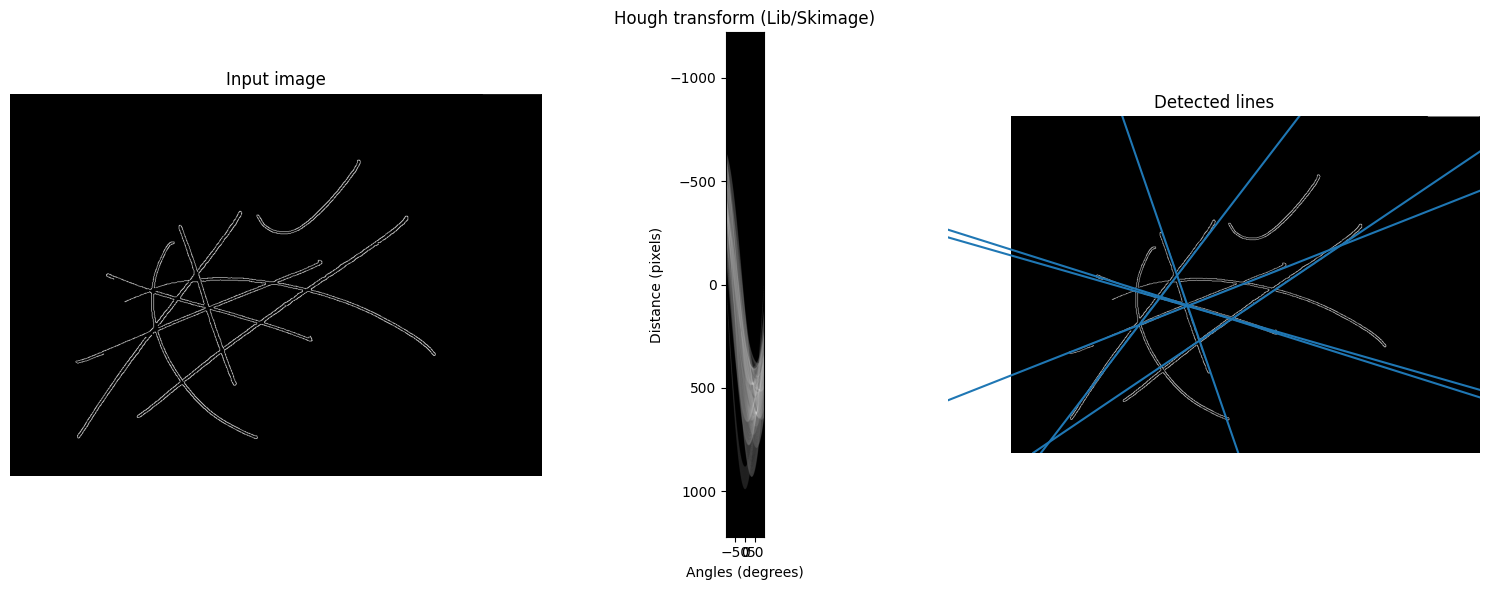

bounds = [[-90, 90, 1219, -1219]]


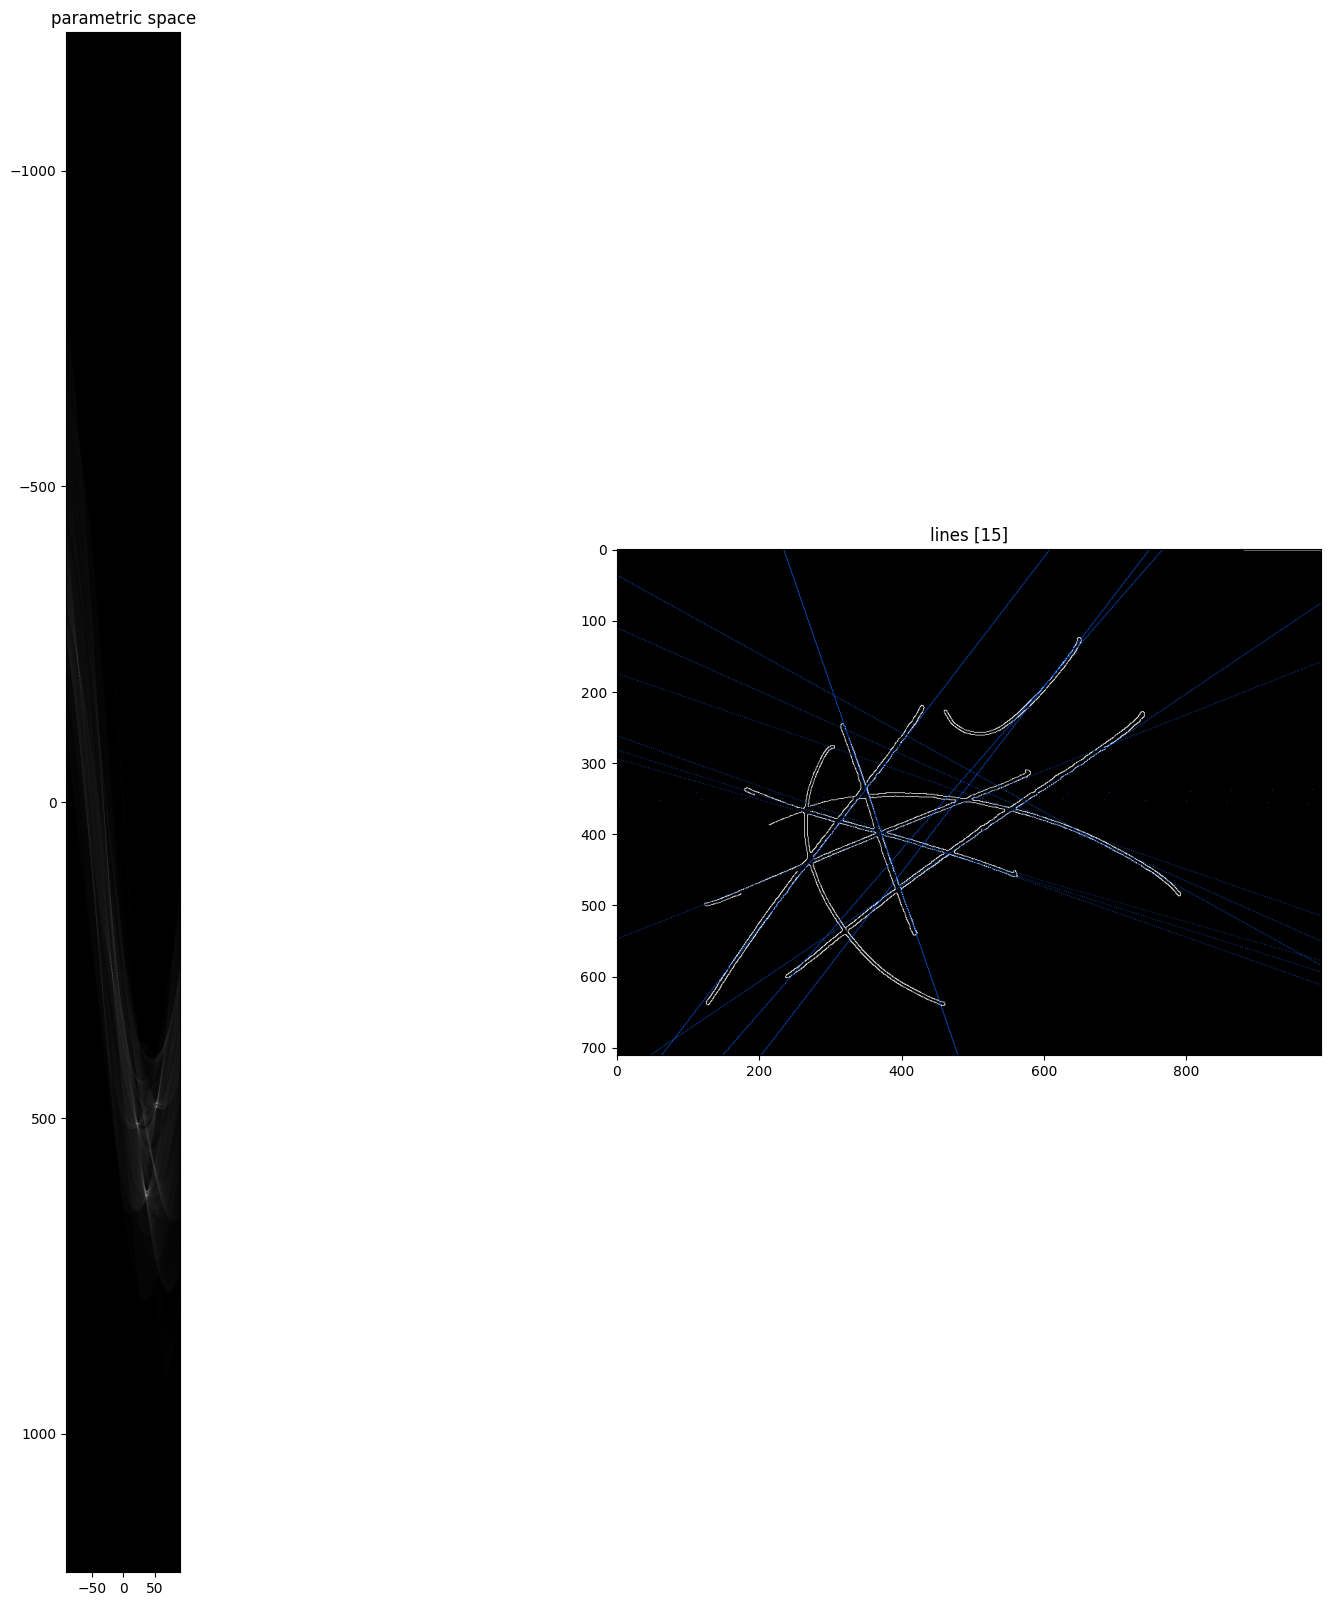

In [427]:
for image in edges_1a:
    hough_lines_lib(image)

    parametric_space, local_maxima, new_image = hough_lines(image)
    parametric_space = normalize_images([parametric_space * 255])[0]

    diagonal = round(np.sqrt(image.shape[0]**2 + image.shape[1]**2))
    show_images_side_by_side(
        parametric_space,
        new_image,
        graph_titles = ['parametric space', f'lines [{len(local_maxima)}]'],
        bounds = [
            [
                -90, 90,
                diagonal, -diagonal
            ]
        ],
    )


## Comentários



# Questão 1.b

Implemente o algoritmo SNAKE. Use imagens disponibilizadas no site (ou outras) e estude as diferenças entre os contornos deformáveis obtidos por diferentes escolhas de alpha_i, beta_i e gama_i. (wallet.jpg, contornos.png). O sistema deve permitir a seleção manual de alguns pontos ao redor do contorno do objeto de forma a definir os pontos iniciais de todo o contorno deformável. O resultado deve ser mostrado de forma a se visualizar o contorno deformável se movendo a cada iteração

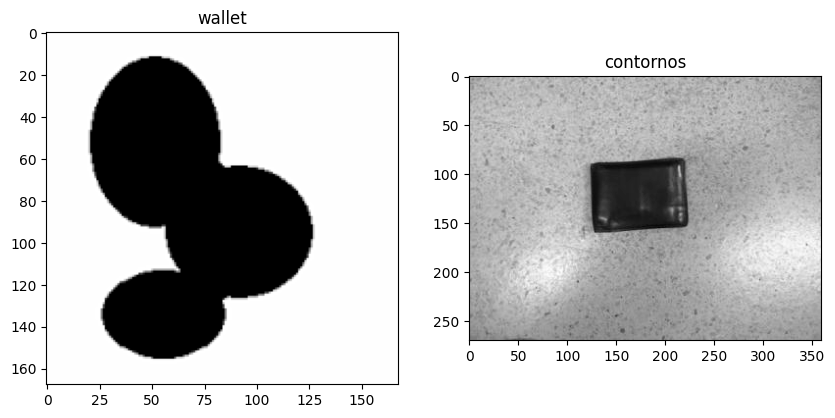

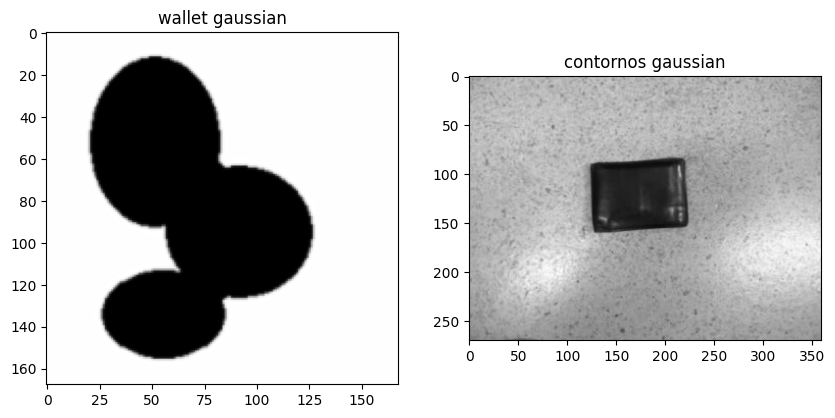

In [428]:
images = ['trab2/wallet.jpg', 'trab2/contornos.png']

IMAGES_1B = load_images(files = images)
show_images_side_by_side(*IMAGES_1B, graph_titles = ['wallet', 'contornos'], figsize=(10, 10))

gaussian_1b = [skimage.filters.gaussian(image, sigma=0.5, preserve_range=True) for image in IMAGES_1B]
show_images_side_by_side(*gaussian_1b, graph_titles = ['wallet gaussian', 'contornos gaussian'], figsize=(10, 10))


#edges_1b = [skimage.feature.canny(image, sigma=2) for image in gaussian_1b]
#display_edges = normalize_images(edges_1b)
#show_images_side_by_side(*display_edges, graph_titles = ['wallet CANNY', 'contornos CANNY'], figsize=(10, 10))

In [429]:
def point_distance(a, b):

    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def min_epsilon_window(image_gradient, points, window_size, alpha, beta, gamma):

    # fit points inside image boundary
    for j in range(len(points)):

        x, y = points[j]
        # drag point to closest point inside image boundary
        if not window_size <= x < image_gradient.shape[0] - window_size:
            x = max(window_size, min(x, image_gradient.shape[0] - 1 - window_size))

        if not window_size <= y < image_gradient.shape[1] - window_size:
            y = max(window_size, min(y, image_gradient.shape[1] - 1 - window_size))

        points[j] = [x, y]


    distances = np.zeros(len(points))
    for i in range(len(points)):
        distances[i] = point_distance(points[i], points[i - 1])

    average_distance = np.mean(distances)

    next_points = np.roll(points, -1, axis=0)
    previous_points = np.roll(points, 1, axis=0)

    previous_distance = np.roll(distances, 1)
    next_distance = np.roll(distances, -1)


    curvature = previous_distance - np.multiply(distances, 2) + next_distance
    k = np.max(curvature) * 0.25

    for i in range(len(points)):

        # get points around the current point in the window_size
        local_neighborhood = []
        window_size = window_size//2
        for x in range(-window_size, window_size + 1):
            for y in range(-window_size, window_size + 1):
                local_neighborhood.append([points[i][0] + x, points[i][1] + y])
        local_neighborhood = np.array(local_neighborhood)

        local_distance = [np.linalg.norm(p - previous_points[i]) for p in local_neighborhood]
        e_contour = (average_distance - local_distance) ** 2

        #e_curvature = [(point_distance(p, previous_points[i]) + point_distance(p, next_points[i]) )**2 for p in local_neighborhood]
        e_curvature = [np.linalg.norm(previous_points[i] - (2 * p) + next_points[i]) ** 2 for p in local_neighborhood]
        # if e_curvature is greater than k, we will set it as zero to penalize it
        e_curvature = [0 if e >= k else e for e in e_curvature]

        e_image = -image_gradient[local_neighborhood[:, 0], local_neighborhood[:, 1]]

        e_internal =  np.multiply(e_contour, alpha) + np.multiply(e_curvature, beta)
        e_external = np.multiply(e_image, gamma)
        energy = e_internal + e_external

        min_energy = np.min(energy)
        min_point = local_neighborhood[np.argmin(energy)]

        next_points[i] = min_point

    return next_points


def snakes(
    image: np.ndarray,
    initial_points,
    alpha: float = 0.1, beta: float = 0.1, gamma: float = 0.1,
    iterations: int = 100, convergence: float = 0.05
):
    #return _snakes(image, initial_points, alpha, beta, gamma, iterations)

    # with the help of:
    # https://github.com/notmatthancock/snakes/blob/master/snake.py
    # and
    # https://github.com/brikeats/Snakes-in-a-Plane/blob/master/snakes.py

    # calculate the gradient of the image
    #smooth = skimage.filters.gaussian(image, sigma=2, preserve_range=True)
    image_gradient = skimage.filters.sobel(image)

    #show_image(image_gradient * 255, 'image gradient')

    # round all points to integers
    points = initial_points
    points = np.round(points).astype(int)

    for i in range(iterations):
        points = min_epsilon_window(image_gradient, points, 5, alpha, beta, gamma)

    return points

def _snakes(image: np.ndarray, initial_points, alpha: float = 0.1, beta: float = 0.1, gamma: float = 0.1, iterations: int = 100):

    # run the snake
    snake = skimage.segmentation.active_contour(
        image,
        initial_points,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        max_num_iter=iterations
    )

    return snake


def draw_snake(image, snake):
    # draw the snake

    # if grascale, create a rgb image
    if len(image.shape) == 2:
        new_image = np.array([image / 255, image / 255, image / 255])
        new_image = np.transpose(new_image, (1, 2, 0))
    else:
        new_image = image.copy()

    COLOR = [255, 0, 0]

    for i in range(0, len(snake)):
        x = int(round(snake[i][0]))
        y = int(round(snake[i][1]))

        # color as blueish color
        if x >= 0 and x < image.shape[0] and y >= 0 and y < image.shape[1]:
            new_image[x][y] = COLOR

            # draw a bigger dot
            if x + 1 < image.shape[0]:
                new_image[x + 1][y] = COLOR
            if x - 1 >= 0:
                new_image[x - 1][y] = COLOR
            if y + 1 < image.shape[1]:
                new_image[x][y + 1] = COLOR
            if y - 1 >= 0:
                new_image[x][y - 1] = COLOR

    return new_image


#        for j in range(len(local_neighborhood)):
#
#            current_point = local_neighborhood[j]
#
#            # get the minimum value
#            # find internal energy
#            e_contour = (average_distance - np.linalg.norm(current_point - previous_points[i])) ** 2
#            e_curvature = np.linalg.norm(previous_points[i] - 2 * current_point + next_points[i]) ** 2
#
#            _beta = beta
#            if e_curvature > k:
#                _beta = 0
#            e_internal = alpha * e_contour + _beta * e_curvature
#
#            # find external energy
#            e_image = - image_gradient[current_point[0], current_point[1]]
#            e_external = gamma * e_image
#
#            energy = e_internal + e_external
#
#            if energy < min_energy:
#                min_energy = energy
#                min_point = current_point


In [430]:
def run_snake_and_show_result(image, alpha, beta, gamma, iterations, steps, num_points, convergence = 0.20):

    # initialize the snake
    # drawing a circle in the image
    NUM_POINTS = num_points
    s = np.linspace(0, 2*np.pi, NUM_POINTS)
    x = image.shape[0]//2 + 100*np.cos(s)
    y = image.shape[1]//2 + 100*np.sin(s)
    initial_points = np.array([x, y]).T
    initial_points = np.round(initial_points).astype(int)

    # snake params
    ALPHA = alpha
    BETA = beta
    GAMMA = gamma
    ITERATIONS = iterations
    STEPS = steps

    snake = initial_points
    new_image = draw_snake(image, snake)

    final_result = snakes(
            image,
            snake,
            alpha=ALPHA,
            beta=BETA,
            gamma=GAMMA,
            iterations=200
        )
    final_image = draw_snake(image, final_result)

    accumulated_image = new_image
    show_images_side_by_side(new_image, final_image, graph_titles=["snakes #0", "(preview 200 iter)" ], figsize=(20, 20))

    # execute snake STEPS times, total of STEPS*ITERATIONS iterations
    _steps = STEPS
    i = 0
    while _steps != 0:
        _steps -= 1

        previous_snake = np.copy(snake)
        snake = snakes(
            image,
            snake,
            alpha=ALPHA,
            beta=BETA,
            gamma=GAMMA,
            iterations=ITERATIONS
        )

        # check how many points moved
        moved_points = 0
        for j in range(len(snake)):
            if snake[j][0] != previous_snake[j][0] or snake[j][1] != previous_snake[j][1]:
                moved_points += 1
        snake_movement = moved_points / len(snake)

        # draw the snake on the screen
        accumulated_image = draw_snake(accumulated_image, snake)
        new_image = draw_snake(image, snake)
        show_images_side_by_side(
            new_image, accumulated_image,
            graph_titles=[f'snakes #{(i + 1)*ITERATIONS} - (mov: {round(100 * snake_movement)}%)', 'Path (Accumulated)'],
            figsize=(15, 15)
        )

        i += 1

        # if less than f% of the points moved, stop
        if snake_movement < convergence or i > 100:
            break



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


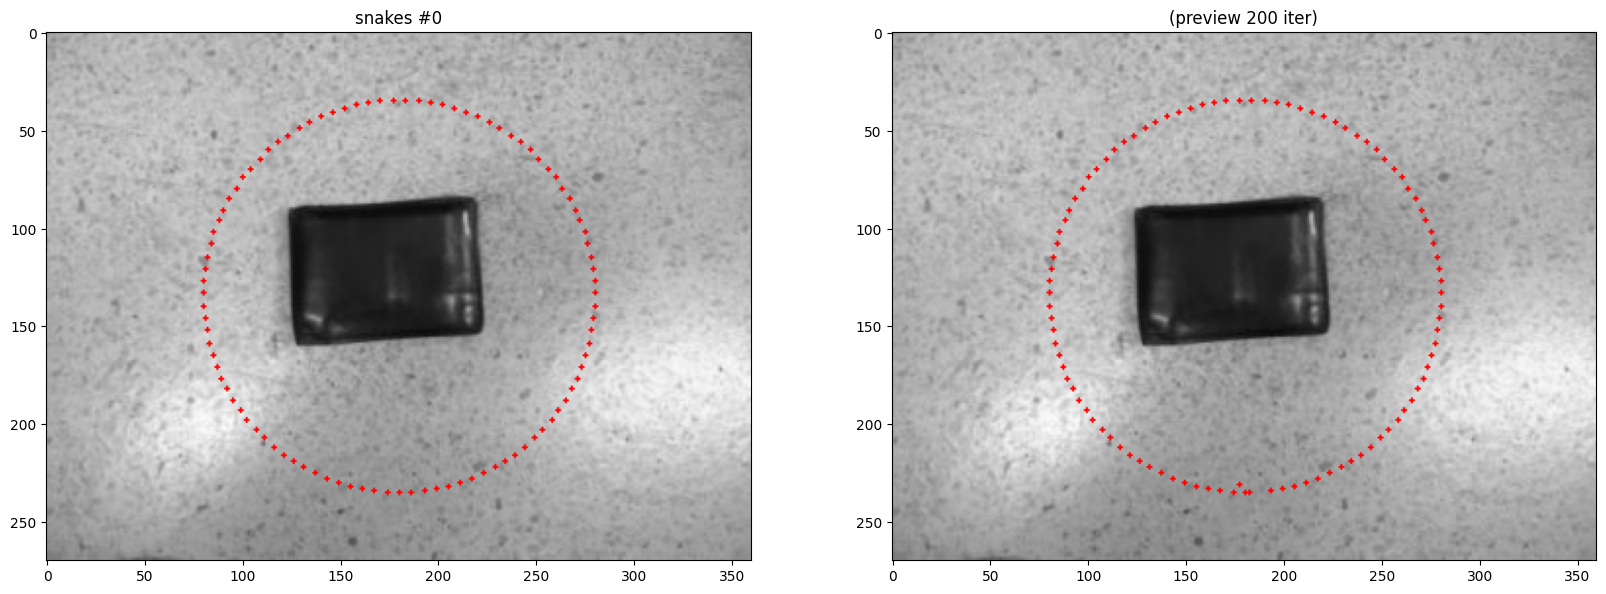

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


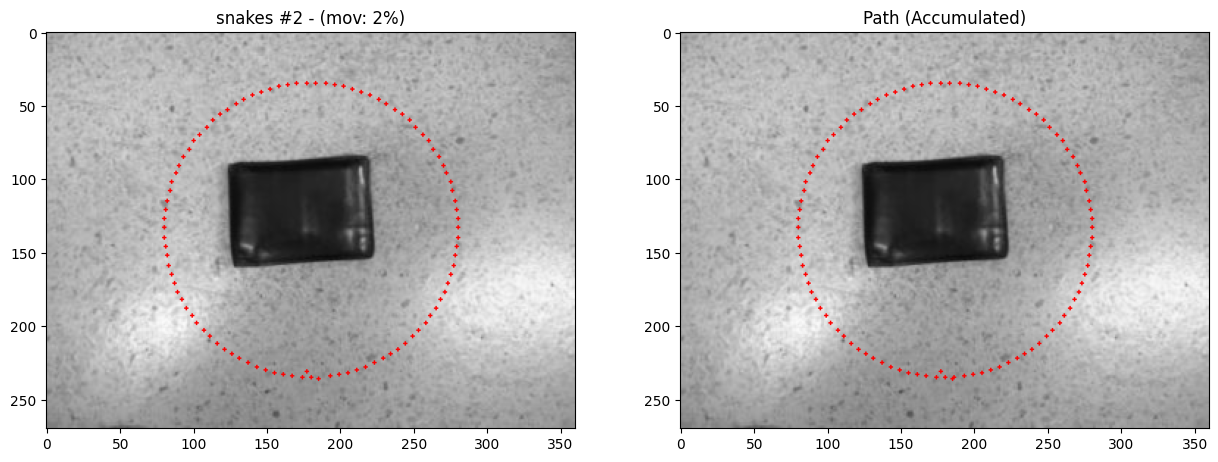

In [431]:
# lib values
# ALPHA = 4.5
# BETA = 3
# GAMMA = 3

NUM_POINTS = 100
ALPHA = 1
BETA = 1
GAMMA = 1
ITERATIONS = 2
STEPS = -1

run_snake_and_show_result(
    gaussian_1b[1],
    ALPHA, BETA, GAMMA,
    ITERATIONS, STEPS, NUM_POINTS,
    convergence=0.10
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


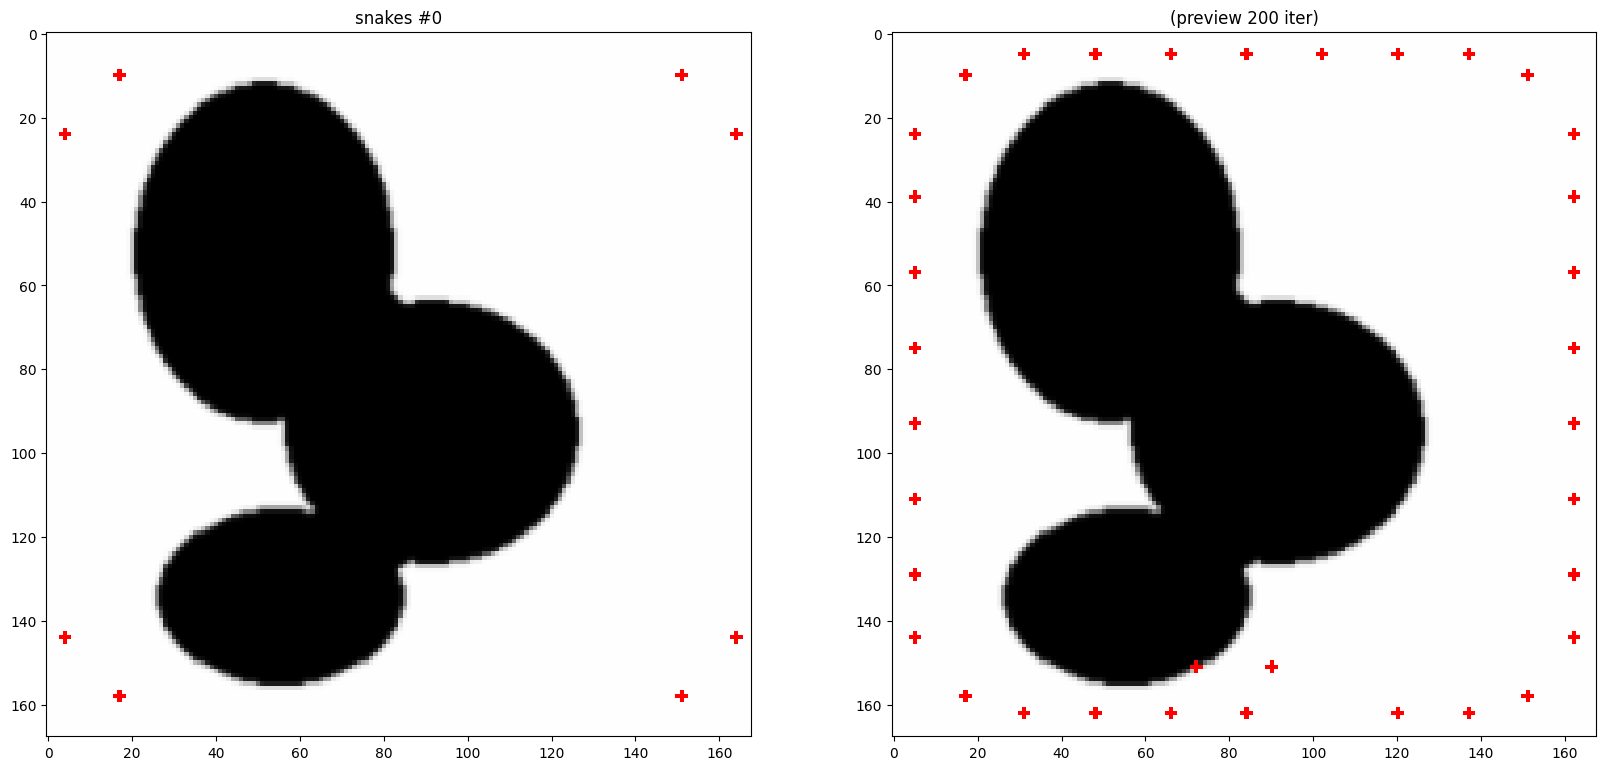

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


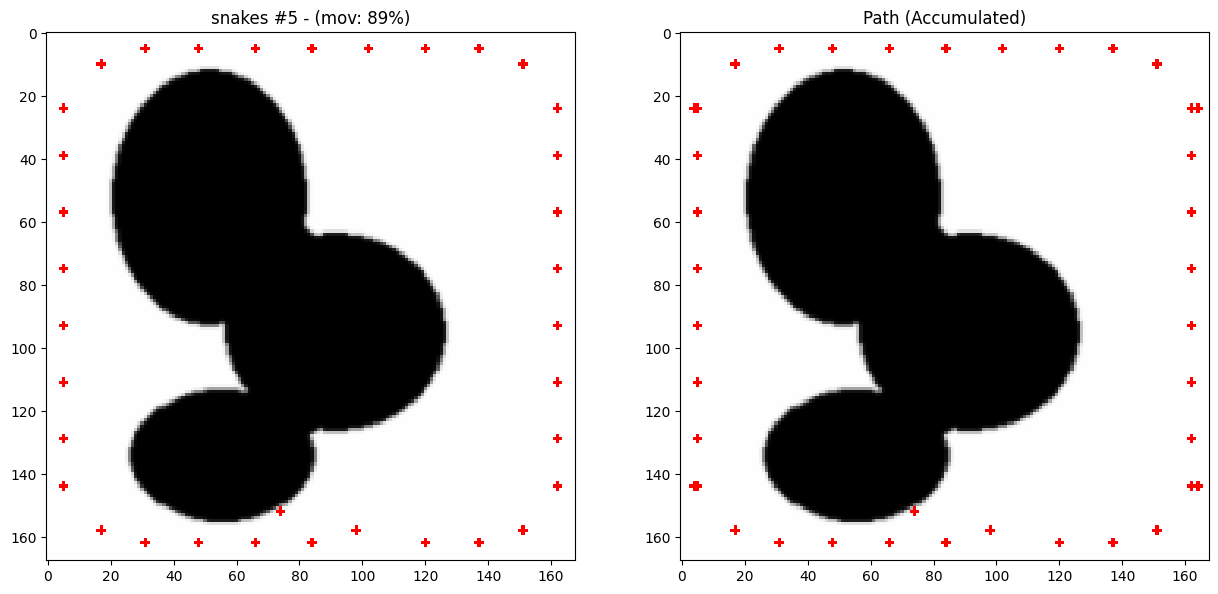

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


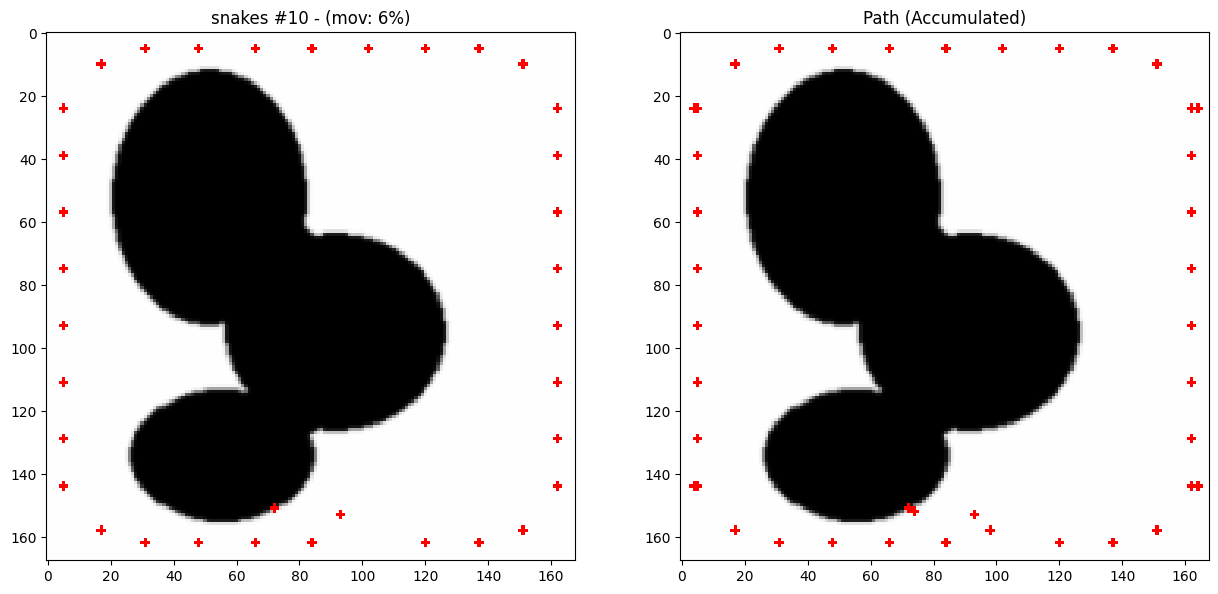

In [432]:
# Values for lib:
#ALPHA = 0.8
#BETA = 0.15
#GAMMA = 0.9

NUM_POINTS = 35
ALPHA = 1
BETA = 1
GAMMA = 1
ITERATIONS = 5
STEPS = -1

run_snake_and_show_result(
    gaussian_1b[0],
    ALPHA, BETA, GAMMA,
    ITERATIONS, STEPS, NUM_POINTS,
    convergence=0.10
)

## Comentário



# Questão 1.c

Projete e implemente um programa (MatLab) que, dado os diversos pares de imagens estéreo disponibilizados (book1.png, cart.png, woodcyl.png), ou outros que achar mais
convenientes, defina pelo menos 8 pontos correspondentes e calcule a matriz fundamental e a localização dos epipolos para cada par. Isso pode ser feito atribuindo valores para os
parâmetros intrínsecos das câmeras, assumindo que ambas são iguais. Observe que se a escolha dos pontos não for adequada não haverá solução. Verifique a precisão do resultado utilizando pontos da imagem não utilizados na estimativa da matriz, traçando linhas epipolares que passem pelos pontos correspondentes na outra imagem. Outras
imagens estereoscópicas podem ser obtidas em: http://www.cs.cmu.edu/afs/cs/project/vision/vasc/idb/www/html_permanent/index.html

In [488]:
def preprocess_image(image):

    # remove gaussian noise
    image = skimage.filters.gaussian(image, sigma=1)

    # gamma correction
    image = skimage.exposure.adjust_gamma(image, gamma=0.5, gain=2)

    return image


def show_keypoints(image, keypoints, color):

    fig, ax = plt.subplots()
    ax.imshow(image, cmap=plt.cm.gray)
    ax.plot(keypoints[:, 1], keypoints[:, 0], color=color, marker='o',linestyle='None', markersize=2)
    plt.show()

def correspondence_points(image_left, image_right):

    # https://scikit-image.org/docs/stable/auto_examples/transform/plot_fundamental_matrix.html
    descriptor_extractor = skimage.feature.ORB(
        n_keypoints=1000,
        fast_n=12,
        fast_threshold=0.05,
        harris_k=0.04,
        n_scales=4,
        downscale=1.2,
    )

    image_left = preprocess_image(image_left)
    image_right = preprocess_image(image_right)

    # find corners
    descriptor_extractor.detect_and_extract(image_left)
    keypoints_left = descriptor_extractor.keypoints
    descriptors_left = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(image_right)
    keypoints_right = descriptor_extractor.keypoints
    descriptors_right = descriptor_extractor.descriptors

    # show keypoints
    #show_keypoints(image_left, keypoints_left, 'red')
    #show_keypoints(image_right, keypoints_right, 'cyan')

    # match corners
    matches = skimage.feature.match_descriptors(
        descriptors_left,
        descriptors_right,
        cross_check=True,
        max_distance=0.5,
        max_ratio=0.8,
        #metric="seuclidean"
    )

    return matches, keypoints_left, keypoints_right


def find_fundamental_matrix(matches, keypoints_left, keypoints_right, image_left, image_right):

    # find fundamental matrix

    # using the 8 points algorithm
    # https://www.cs.cmu.edu/~16385/s17/Slides/12.4_8Point_Algorithm.pdf

    # normalize points coordinates
    keypoints_left = keypoints_left / image_left.shape
    keypoints_right = keypoints_right / image_right.shape

    # construct A matrix
    A = np.zeros((len(matches), 9))
    for i, match in enumerate(matches):
        x1, y1 = keypoints_left[match[0]]
        x2, y2 = keypoints_right[match[1]]
        A[i] = [x1 * x2, x1 * y2, x1, y1 * x2, y1 * y2, y1, x2, y2, 1]


    # find SVD of A
    U, S, V = np.linalg.svd(A)

    # Entries of F are the elements of column of V corresponding to the least singular value
    F = V[-1].reshape(3, 3)

    # Enforce rank 2 constraint
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = U @ np.diag(S) @ V

    return F

    # using skimage:

    # only use the first 8 matches
    #model, inliers = skimage.measure.ransac((keypoints_left[matches[:, 0]],
    #                     keypoints_right[matches[:, 1]]),
    #                    skimage.transform.FundamentalMatrixTransform, min_samples=8,
    #                    residual_threshold=1, max_trials=5000,
    #                    random_state=np.random.default_rng(0))
    #fundamental_matrix = skimage.transform.FundamentalMatrixTransform()
    #fundamental_matrix.estimate(keypoints_left[matches[:, 0]], keypoints_right[matches[:, 1]])



def epipole_location(fundamental_matrix, image_left, image_right):

    # https://www.cs.auckland.ac.nz/courses/compsci773s1t/lectures/773-GG/lectA-773.htm

    # scipy uses SVD to find tjhe null space values
    # the left epipole is the null space of the fundamental matrix
    left_epipole = scipy.linalg.null_space(fundamental_matrix).flatten()
    left_epipole = left_epipole[0] * image_left.shape[1], left_epipole[1] * image_left.shape[0], left_epipole[2]

    # and the right epipole is the null space of the transpose of the fundamental matrix
    right_epipole = scipy.linalg.null_space(fundamental_matrix.T).flatten()
    right_epipole = right_epipole[0] * image_right.shape[1], right_epipole[1] * image_right.shape[0], right_epipole[2]

    return left_epipole, right_epipole

def drawlines(img1, img2, lines, pts1, pts2, epipole):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    
    # https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html#:~:text=Epipole%20is%20the%20point%20of,'t%20see%20the%20other).

    h, w = image_left.shape

    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, pts1, pts2):

        color = tuple(np.random.randint(0,255,3).tolist())

        a, b, c = r.ravel()

        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        
        pt1 = tuple(map(int, pt1))
        pt2 = tuple(map(int, pt2))

        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1, pt1, 5, color, -1)

        img2 = cv.circle(img2, pt2, 5, color, -1)

    return img1, img2




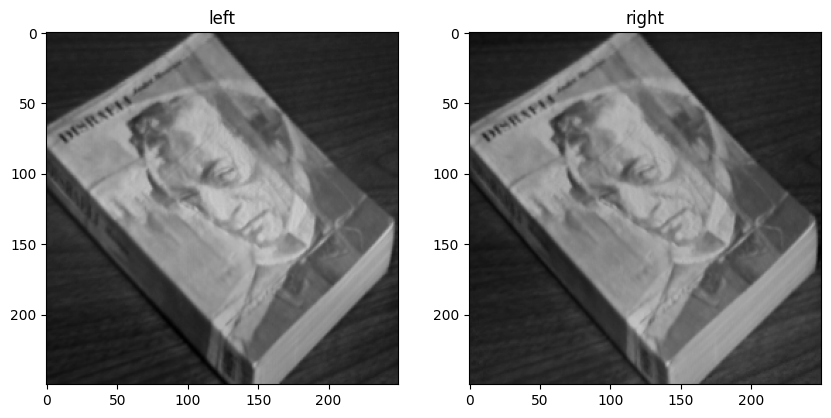

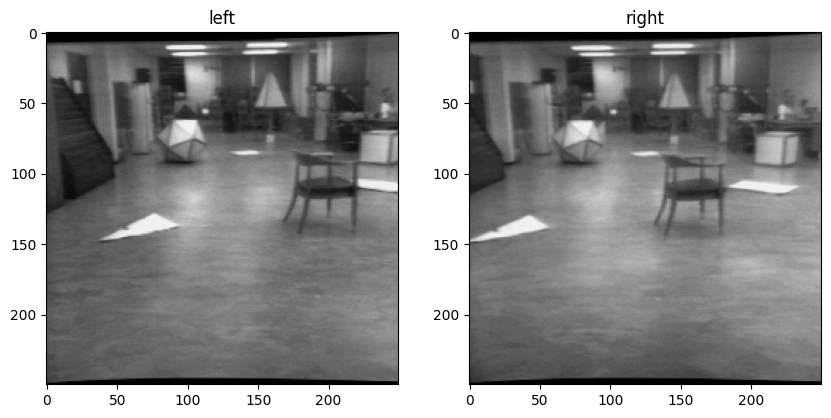

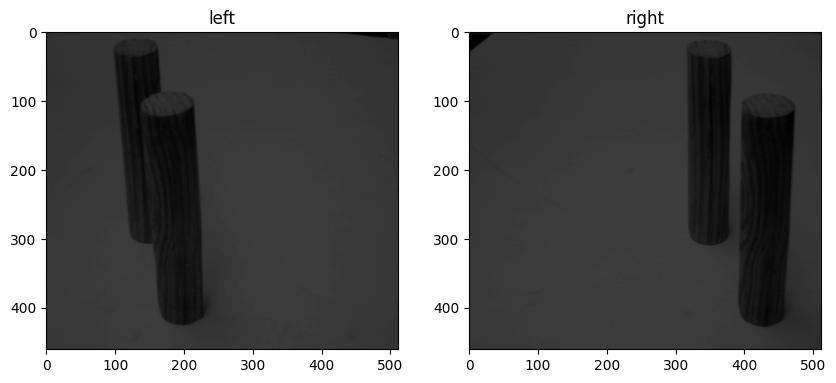

In [489]:
filenames_left = ['trab2/book1left.png', 'trab2/cartleft.png', 'trab2/woodcylleft.png']
filenames_right = ['trab2/book1right.png', 'trab2/cartright.png', 'trab2/woodcylright.png']

IMAGES_1C_LEFT = load_images(files = filenames_left)
IMAGES_1C_RIGHT = load_images(files = filenames_right)

# cut botton of image 3
IMAGES_1C_LEFT[2] = IMAGES_1C_LEFT[2][:IMAGES_1C_RIGHT[2].shape[0] - IMAGES_1C_LEFT[2].shape[0]//10, :]
IMAGES_1C_RIGHT[2] = IMAGES_1C_RIGHT[2][:IMAGES_1C_RIGHT[2].shape[0] - IMAGES_1C_RIGHT[2].shape[0]//10, :]



for i in range(len(IMAGES_1C_LEFT)):
    show_images_side_by_side(IMAGES_1C_LEFT[i], IMAGES_1C_RIGHT[i], graph_titles=['left', 'right'], figsize=(10, 10))



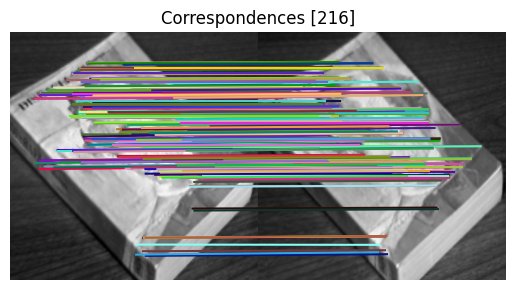

Fundamental matrix: 
 [[ 0.02185855  0.59025899 -0.2911754 ]
 [-0.59474449  0.00094637  0.25794775]
 [ 0.27984454 -0.26029709  0.00263242]]
Left epipole: (91.26270088967317, 100.2405337398517, 0.840218588910021)
Right epipole: (92.00855571606812, 101.72766341987818, 0.8360469668163399)


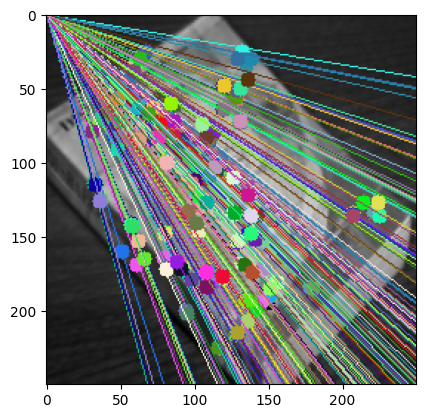

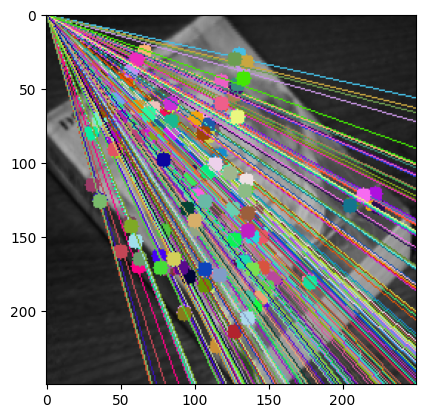

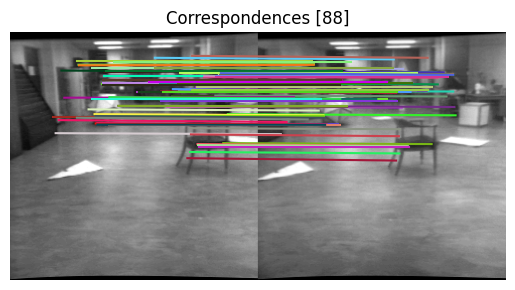

Fundamental matrix: 
 [[-0.13223893 -0.59661929  0.36433155]
 [ 0.56751468  0.01077671 -0.19008659]
 [-0.31824187  0.18494937  0.00370842]]
Left epipole: (68.71630833046122, 113.99678285966213, 0.8464779025309996)
Right epipole: (-65.459495241337, -129.43611105740447, -0.814482389124132)


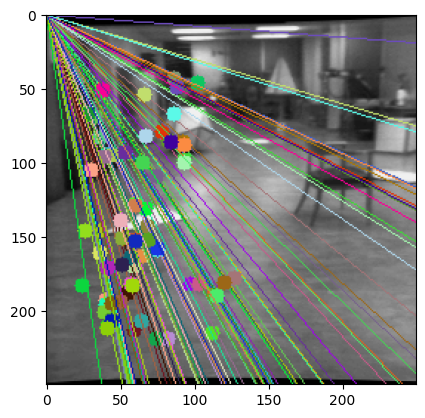

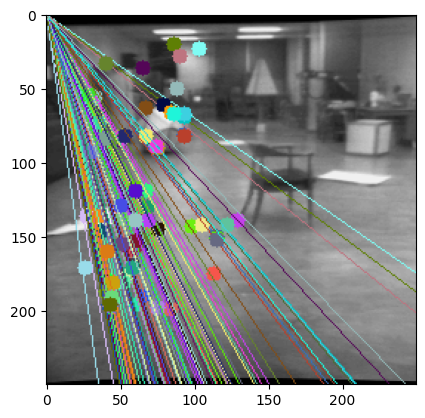

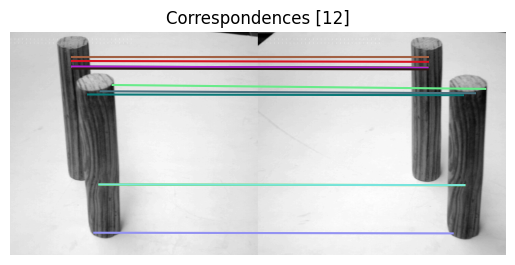

Fundamental matrix: 
 [[-0.03158533 -0.45423707  0.36522758]
 [ 0.72852487  0.04505896 -0.25463888]
 [-0.21810802  0.11599802 -0.02516868]]
Left epipole: (118.09852097106257, 276.56635614476187, 0.7660828896301286)
Right epipole: (-134.98881634222033, -132.36716623711433, -0.9208934408999432)


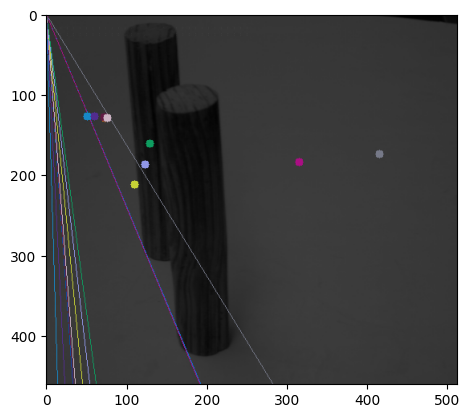

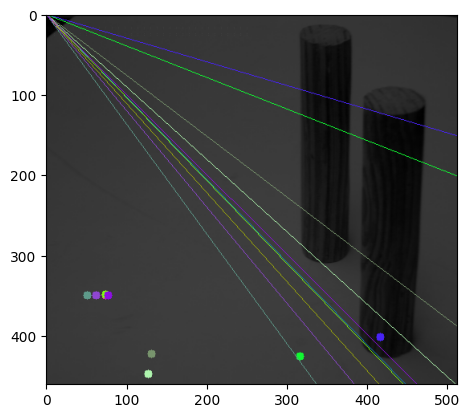

In [490]:
for i in range(len(IMAGES_1C_LEFT)):

    image_left, image_right = IMAGES_1C_LEFT[i], IMAGES_1C_RIGHT[i]

    matches, keypoints_left, keypoints_right = correspondence_points(image_left, image_right)

    points_left = keypoints_left[matches[:, 0]]
    points_right = keypoints_right[matches[:, 1]]

    fig, ax = plt.subplots()
    skimage.feature.plot_matches(
        ax, image_left, image_right, keypoints_left, keypoints_right, matches,
        only_matches=True
    )
    ax.axis('off')
    ax.set_title(f'Correspondences [{len(matches)}]')
    plt.show()

    f_matrix = find_fundamental_matrix(matches, keypoints_left, keypoints_right, image_left, image_right)

    print(f"Fundamental matrix: \n {f_matrix}")

    left_epipole, right_epipole = epipole_location(f_matrix, image_left, image_right)

    print(f"Left epipole: {left_epipole}")
    print(f"Right epipole: {right_epipole}")


    lines1 = cv.computeCorrespondEpilines(points_right.reshape(-1,1,2), 2, f_matrix)
    img5,img6 = drawlines(image_left, image_right, lines1, points_left, points_right, right_epipole)

    lines2 = cv.computeCorrespondEpilines(points_left.reshape(-1,1,2), 1, f_matrix)
    img3,img4 = drawlines(image_right, image_left, lines2, points_right, points_left, left_epipole)

    plt.imshow(img5)
    plt.show()
    plt.imshow(img3)
    plt.show()

